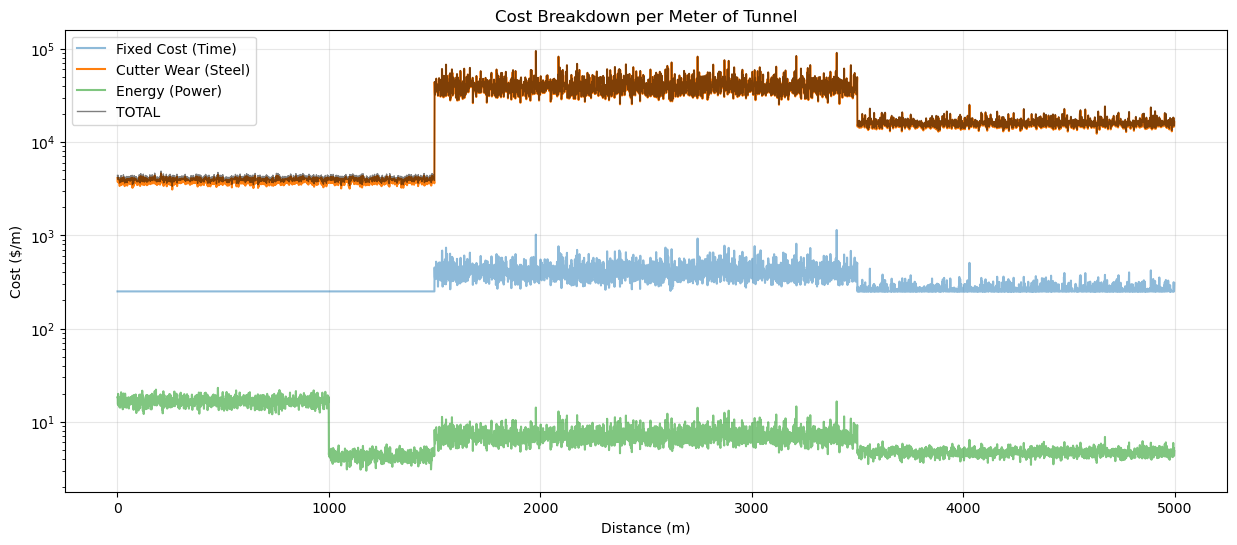

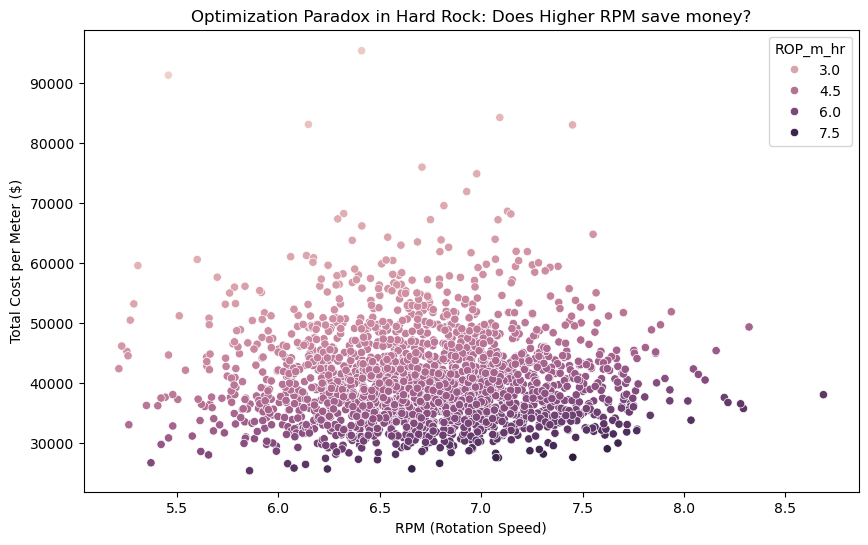

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

NB_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NB_DIR)
RAW_DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'raw')
os.makedirs(RAW_DATA_DIR, exist_ok=True)
FIGURES_DIR = os.path.join(PROJECT_ROOT,'data', 'reports', 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
csv_path =  os.path.join(RAW_DATA_DIR, 'raw_tunnel_data.csv')

df = pd.read_csv(csv_path)

# A 17-inch disc cutter costs ~$1,500.
# In hard granite, a cutter might last only 5 hours.
PRICE_PER_CUTTER = 1500 # $
# Calibration factor for our synthetic formula
WEAR_FACTOR = 0.0005  # how to calc in real data?

PRICE_GRID = 0.09
PRICE_DIESEL = 0.35 # usd per KWh



# Power (kW) ~ Thrust * RPM * Constant
df['Power_kW'] = (df['Thrust_KN'] * df['RPM']) / 100

# Assume we are on Diesel for the first 1km (remote), then Grid connects.
df['Energy_Price'] = np.where(df.index < 1000, PRICE_DIESEL, PRICE_GRID)

df['Energy_Cost_m'] = (df['Power_kW'] * df['Energy_Price']) / df['ROP_m_hr']

#  (Power_kW * energy_price / ROP)  = Energy Cost

# (Cutter_Cost_Factor / ROP) = Wear Cost (Fast RPM is expensive)

# Wear ~ UCS^2 * RPM / ROP
# Harder rock + Faster spin = More wear per meter.

df['Cutter_Wear_Index'] = (df['UCS_MPa']**2 * df['RPM']) * WEAR_FACTOR

df['Cutter_Cost_m'] =  (df['Cutter_Wear_Index'] * PRICE_PER_CUTTER / df['ROP_m_hr'])


Fixed_Cost_Hourly = 2000 # large project

# (Fixed_Cost_Hourly / ROP) =         # Time Cost (Slow is expensive)

df['Time_Cost_m'] = Fixed_Cost_Hourly / df['ROP_m_hr']

df['Total_Cost_m'] = df['Time_Cost_m'] + df['Cutter_Cost_m'] + df['Energy_Cost_m']

df


# Plot 1: The Cost Components (Stacked)
plt.figure(figsize=(15, 6))
plt.plot(df['Chainage_m'], df['Time_Cost_m'], label='Fixed Cost (Time)', alpha=0.5)
plt.plot(df['Chainage_m'], df['Cutter_Cost_m'], label='Cutter Wear (Steel)', alpha=1)
plt.plot(df['Chainage_m'], df['Energy_Cost_m'], label='Energy (Power)', alpha=0.6)
plt.plot(df['Chainage_m'], df['Total_Cost_m'], label='TOTAL', color='black', linewidth=1, alpha = 0.5)
plt.yscale('log')  # Add this after plt.plot() calls
plt.legend()
plt.title('Cost Breakdown per Meter of Tunnel')
plt.ylabel('Cost ($/m)')
plt.xlabel('Distance (m)')
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: The "Sweet Spot" Trade-off (The Lesson)
# Filter for Hard Rock only to see the wear effect clearly
hard_rock = df[df['UCS_MPa'] > 180]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=hard_rock['RPM'], y=hard_rock['Total_Cost_m'], hue=hard_rock['ROP_m_hr'])
plt.title('Optimization Paradox in Hard Rock: Does Higher RPM save money?')
plt.xlabel('RPM (Rotation Speed)')
plt.ylabel('Total Cost per Meter ($)')
plt.show()

so our goal here is to do these things

run monte carlo

optiize for cost fxn
know/predict the rop

using the cost fxn optimization we find out the best advacne rate for a fixed ucs (rock type)
so basically

first our scipy picks a random rock type, asks xgb to predict the rop, with that rop it runs the cost fxn

----


soouuu

first we assume a rock type ucs = 150

then we run
to optimize the cost fxn, the scipy uses different thrusts and rpms values for that fixed ucs
it asks xgb for rop values for the diff thrust and rpims the scipy sets so it can actually calc the cost
then for ucs = 150 the rop is set for minimum cost

but the problem is i said the ucs = 150 
i dont know if its 150 (my job is to predict and assess) not asses what we alr know
but what we alr know is also an overstatement becaues they dont drill boreholes at every point in tunnel
its a step jump and anything can be in between, i need to be ready
eg: a and b (500m aparat) are both granite, so the whole must be granite, but in himalays shear zones are full of pressurized mud and water, tbm gets stuck on mud

when doing actual work we cannot be deterministic, ucs - 150 tho that maybe required for loans and invetments and a genreal schedule to follow for MD
so we speak probability

so from satellite or other predictive ai
i test to find out the min cost that incurrs on the rock type (ucs = ?)
so we use monte calro to change the scneraio what if its hard or its soft
can we handle them
if its leaning more towards it cant 
i need to take the loan thingies earlier or notify MD
and then also if things are not dire
just an early info to site engineers is good.
